# Digit Recognizer - Polar Coordinates Experiment

Эксперимент: добавление полярного представления изображений как дополнительного канала

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import map_coordinates

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Device: cuda


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (42000, 785)
Test shape: (28000, 784)


## Polar Coordinates Transformation

Преобразуем изображение 28x28 в полярные координаты:
- Центр = центр масс изображения (для лучшего центрирования)
- Радиус: 0 → max_radius
- Угол: 0 → 2π

In [3]:
def cartesian_to_polar(image, output_size=28):
    """
    Convert 28x28 image to polar coordinates representation.
    Uses center of mass as the origin for better centering.
    
    Output: (output_size, output_size) where:
        - rows = radius (0 to max_radius)
        - cols = angle (0 to 2π)
    """
    h, w = image.shape
    
    # Find center of mass for better centering
    if image.sum() > 0:
        y_coords, x_coords = np.mgrid[0:h, 0:w]
        total_mass = image.sum()
        center_y = (y_coords * image).sum() / total_mass
        center_x = (x_coords * image).sum() / total_mass
    else:
        center_y, center_x = h / 2, w / 2
    
    # Max radius from center to corner
    max_radius = np.sqrt(max(center_x, w - center_x)**2 + max(center_y, h - center_y)**2)
    
    # Create polar grid
    radius = np.linspace(0, max_radius, output_size)
    theta = np.linspace(0, 2 * np.pi, output_size, endpoint=False)
    
    # Meshgrid for polar coordinates
    r_grid, theta_grid = np.meshgrid(radius, theta, indexing='ij')
    
    # Convert back to cartesian for sampling
    x_cart = center_x + r_grid * np.cos(theta_grid)
    y_cart = center_y + r_grid * np.sin(theta_grid)
    
    # Sample from original image using bilinear interpolation
    polar_image = map_coordinates(image, [y_cart, x_cart], order=1, mode='constant', cval=0)
    
    return polar_image.astype(np.float32)

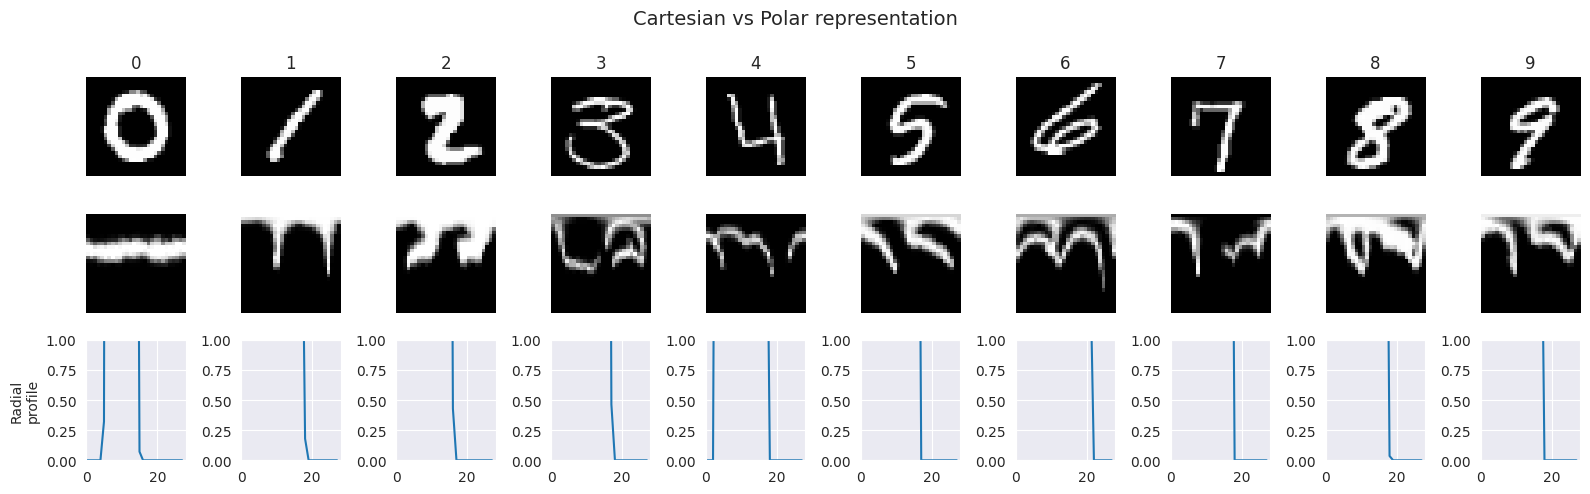

In [4]:
# Visualize polar transformation for each digit
fig, axes = plt.subplots(3, 10, figsize=(16, 5))

for digit in range(10):
    sample = train_df[train_df['label'] == digit].iloc[0, 1:].values.reshape(28, 28)
    polar = cartesian_to_polar(sample)
    
    axes[0, digit].imshow(sample, cmap='gray')
    axes[0, digit].set_title(f'{digit}')
    axes[0, digit].axis('off')
    
    axes[1, digit].imshow(polar, cmap='gray')
    axes[1, digit].axis('off')
    
    # Difference in radial distribution
    radial_profile = polar.mean(axis=1)
    axes[2, digit].plot(radial_profile)
    axes[2, digit].set_xlim(0, 28)
    axes[2, digit].set_ylim(0, 1)

axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('Polar')
axes[2, 0].set_ylabel('Radial\nprofile')

plt.suptitle('Cartesian vs Polar representation', fontsize=14)
plt.tight_layout()
plt.show()

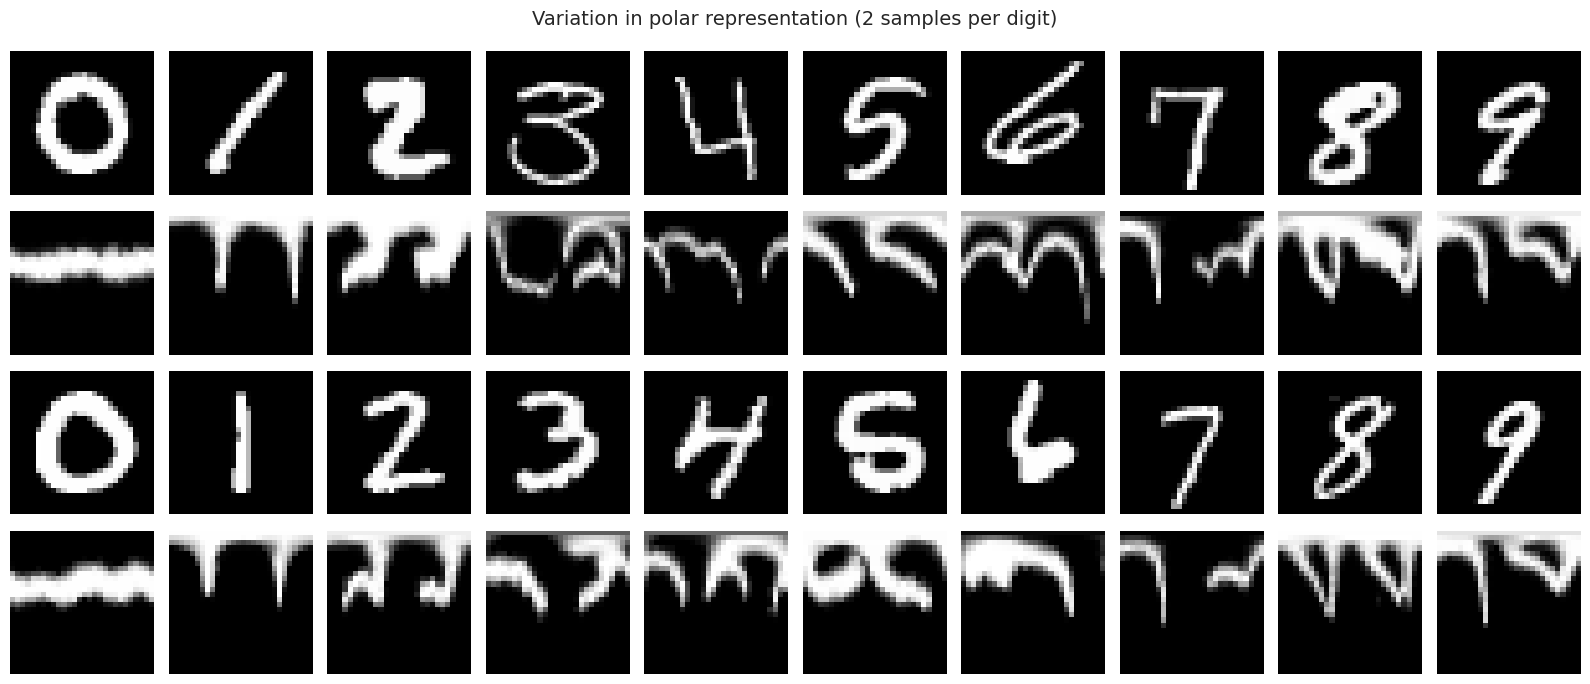

In [5]:
# More examples to see variation
fig, axes = plt.subplots(4, 10, figsize=(16, 7))

for i in range(10):
    samples = train_df[train_df['label'] == i].iloc[:2, 1:].values
    
    for j, sample in enumerate(samples):
        img = sample.reshape(28, 28)
        polar = cartesian_to_polar(img)
        
        axes[j*2, i].imshow(img, cmap='gray')
        axes[j*2, i].axis('off')
        axes[j*2+1, i].imshow(polar, cmap='gray')
        axes[j*2+1, i].axis('off')

plt.suptitle('Variation in polar representation (2 samples per digit)', fontsize=14)
plt.tight_layout()
plt.show()

## Prepare Data with Dual Channels

In [6]:
def prepare_dual_channel_data(df, has_label=True):
    """Prepare data with both cartesian and polar channels."""
    if has_label:
        X = df.drop('label', axis=1).values
        y = df['label'].values
    else:
        X = df.values
        y = None
    
    n_samples = len(X)
    
    # Normalize
    X = X / 255.0
    
    # Create dual channel: [cartesian, polar]
    X_dual = np.zeros((n_samples, 2, 28, 28), dtype=np.float32)
    
    for i in range(n_samples):
        img = X[i].reshape(28, 28)
        X_dual[i, 0] = img  # Cartesian channel
        X_dual[i, 1] = cartesian_to_polar(img)  # Polar channel
        
        if (i + 1) % 5000 == 0:
            print(f'Processed {i + 1}/{n_samples}')
    
    return X_dual, y

In [7]:
print('Processing train data...')
X, y = prepare_dual_channel_data(train_df, has_label=True)

print('\nProcessing test data...')
X_test, _ = prepare_dual_channel_data(test_df, has_label=False)

print(f'\nX shape: {X.shape}')
print(f'X_test shape: {X_test.shape}')

Processing train data...
Processed 5000/42000
Processed 10000/42000
Processed 15000/42000
Processed 20000/42000
Processed 25000/42000
Processed 30000/42000
Processed 35000/42000
Processed 40000/42000

Processing test data...
Processed 5000/28000
Processed 10000/28000
Processed 15000/28000
Processed 20000/28000
Processed 25000/28000

X shape: (42000, 2, 28, 28)
X_test shape: (28000, 2, 28, 28)


In [8]:
# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y
)

print(f'Train: {X_train.shape}')
print(f'Val: {X_val.shape}')

Train: (37800, 2, 28, 28)
Val: (4200, 2, 28, 28)


In [9]:
# DataLoaders
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## CNN Model with 2 Input Channels

In [10]:
class DualChannelCNN(nn.Module):
    """CNN that takes both cartesian and polar representations as input channels."""
    
    def __init__(self):
        super(DualChannelCNN, self).__init__()
        
        # Input: 2 channels (cartesian + polar)
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout1(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

In [11]:
model = DualChannelCNN().to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal params: {total_params:,}')

DualChannelCNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Total params: 391,146


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## Training

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [14]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_polar.pth')
    
    print(f'Epoch [{epoch+1}/{EPOCHS}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

print(f'\n🏆 Best Val Accuracy: {best_val_acc:.2f}%')

Epoch [1/15] | Train Loss: 0.3579 | Train Acc: 88.57% | Val Loss: 0.0835 | Val Acc: 97.50%
Epoch [2/15] | Train Loss: 0.1187 | Train Acc: 96.27% | Val Loss: 0.0500 | Val Acc: 98.57%
Epoch [3/15] | Train Loss: 0.0897 | Train Acc: 97.24% | Val Loss: 0.0428 | Val Acc: 98.74%
Epoch [4/15] | Train Loss: 0.0775 | Train Acc: 97.67% | Val Loss: 0.0449 | Val Acc: 98.64%
Epoch [5/15] | Train Loss: 0.0669 | Train Acc: 97.96% | Val Loss: 0.0374 | Val Acc: 98.71%
Epoch [6/15] | Train Loss: 0.0592 | Train Acc: 98.19% | Val Loss: 0.0420 | Val Acc: 98.81%
Epoch [7/15] | Train Loss: 0.0546 | Train Acc: 98.33% | Val Loss: 0.0356 | Val Acc: 98.95%
Epoch [8/15] | Train Loss: 0.0522 | Train Acc: 98.46% | Val Loss: 0.0345 | Val Acc: 99.07%
Epoch [9/15] | Train Loss: 0.0466 | Train Acc: 98.59% | Val Loss: 0.0363 | Val Acc: 99.05%
Epoch [10/15] | Train Loss: 0.0428 | Train Acc: 98.67% | Val Loss: 0.0327 | Val Acc: 99.05%
Epoch [11/15] | Train Loss: 0.0403 | Train Acc: 98.77% | Val Loss: 0.0286 | Val Acc: 99.3

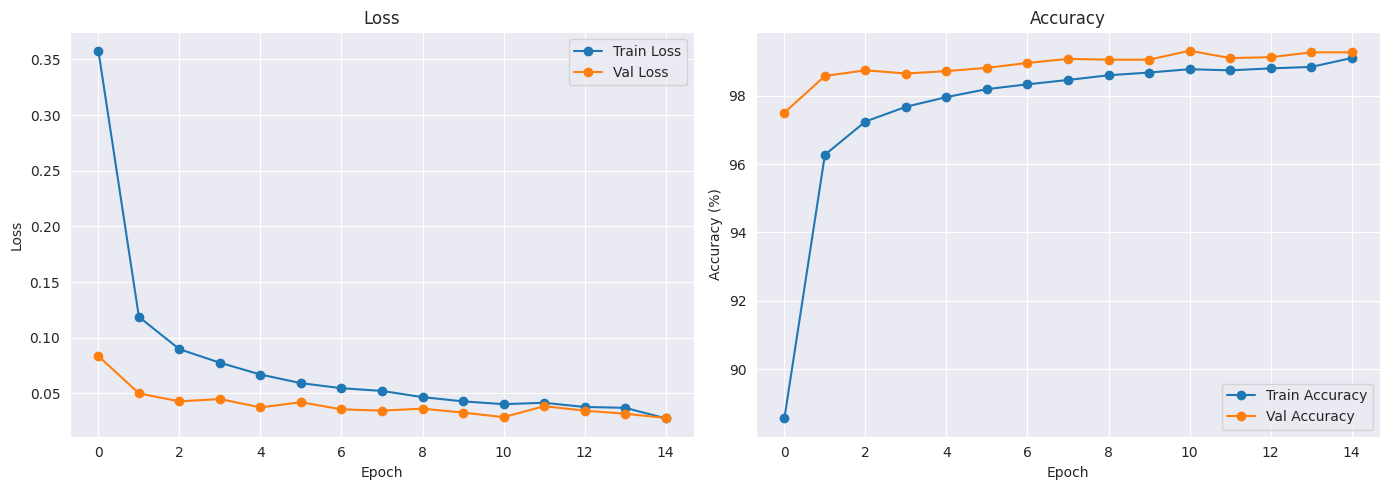

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Predictions & Submission

In [16]:
model.load_state_dict(torch.load('best_model_polar.pth'))
model.eval()

predictions = []

with torch.no_grad():
    for (inputs,) in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        predictions.extend(preds.cpu().numpy())

predictions = np.array(predictions)
print(f'Total predictions: {len(predictions)}')

Total predictions: 28000


In [17]:
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

submission.to_csv('submission_polar.csv', index=False)
print('✅ submission_polar.csv created!')
submission.head(10)

✅ submission_polar.csv created!


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


## Comparison: Baseline vs Polar

После запуска сравните результаты:
- **Baseline (1 channel)**: 99.264%
- **Polar (2 channels)**: 0.99067%

Если полярное представление не помогло — это тоже ценный результат для понимания, какие признаки важны для MNIST.